In [ ]:
#!pip install statsmodels ISLP l0bnb --upgrade

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from datetime import datetime

import statsmodels.api as sm
from statsmodels.stats.outliers_influence \
     import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)

### Data transformation

In [ ]:
Auto = pd.read_csv("clean_auto_ria.csv", parse_dates=[
    'addDate','updateDate','soldDate','expireDate','level_expireDate'
])
Auto = Auto.set_index("autoId")

Here, I am creating and transforming variables, which type wasn't detected automatically.

In [ ]:
Auto['minMonthLeasingBuPay'] = pd.to_numeric(Auto['minMonthLeasingBuPay'].str.replace(' ', ''))

Auto['age'] = datetime.now().year - Auto['year']

# replace NaN with "" then take length
Auto['descriptionLen'] = Auto['description'].fillna('').str.len()

# lets get rid of ouliers
Auto = Auto[
    (Auto['raceInt'] <= 2000) &
    (Auto['UAH']    <= 5_000_000)
].copy()


### Transforming engineVolume to litres and numeric column
numbers = (
    Auto['engineVolume']
      .astype(str)
      .str.extract(r'([\d\.]+)', expand=False)
      .astype(float)
)

# build a mask for cm³ entries
is_cm3 = Auto['engineVolume'].astype(str).str.contains('см', na=False)

# divide those by 1000, leave the rest as is
Auto['engineVolume_l'] = numbers.where(~is_cm3, numbers.div(1000))

In [ ]:
Auto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18620 entries, 38396989 to 37927275
Data columns (total 69 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Unnamed: 0                18620 non-null  int64         
 1   title                     18620 non-null  object        
 2   linkToView                18615 non-null  object        
 3   plateNumber               12185 non-null  object        
 4   markName                  18620 non-null  object        
 5   modelName                 18615 non-null  object        
 6   categoryName              18595 non-null  object        
 7   bodyName                  18613 non-null  object        
 8   modificationName          9743 non-null   object        
 9   UAH                       18620 non-null  int64         
 10  EUR                       18620 non-null  int64         
 11  USD                       18620 non-null  int64         
 12  minMonthLeasi

As we see above we have huge dataset, we need to drop variables that isn't numerical and can't be turn into categorical.

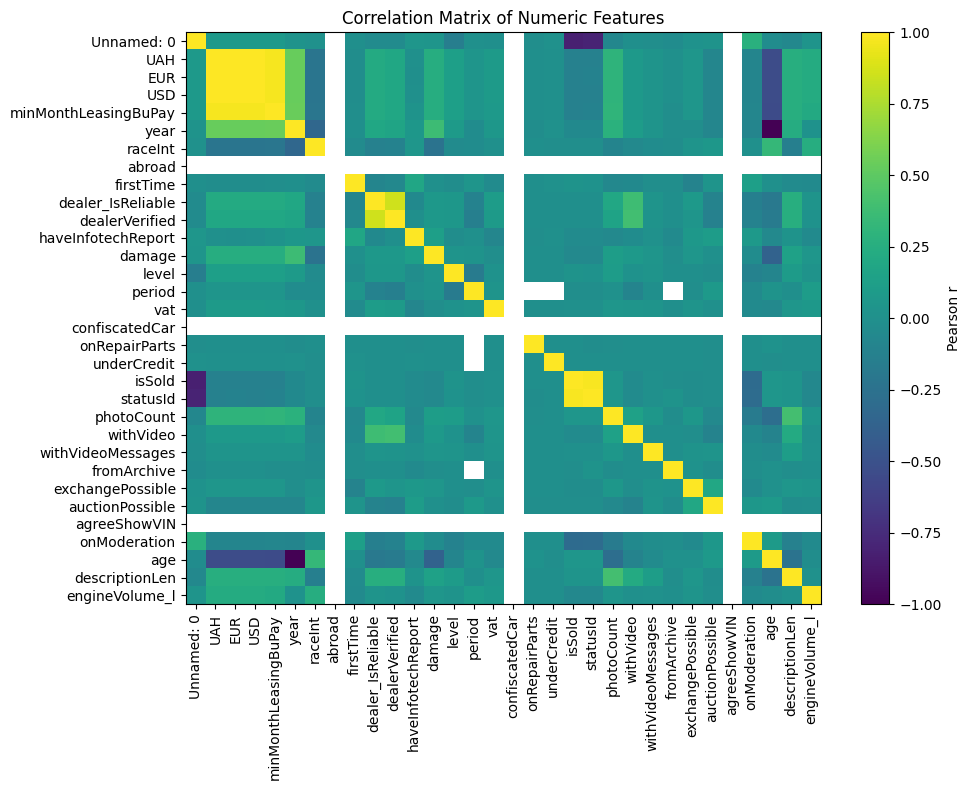

In [ ]:
corr = Auto.corr(numeric_only=True)

plt.figure(figsize=(10,8))
plt.imshow(corr, aspect='auto')
plt.colorbar(label='Pearson r')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

# Linear Models


In [ ]:
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from l0bnb import fit_path

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# drop columns that would blow up the model matrix or not relevant
drop_cols = [
    'Unnamed: 0', 'title', 'description', 'seoLinkB', 'seoLinkF', 'seoLinkM',
    'linkToView', 'plateNumber', 'VIN', 'modificationName', 'equipmentName',
    'generationName', 'infoBarText', 'version', 'USD', 'EUR', 'year', 'race',
    'engineVolume', 'equipmentName', 'generationName', 'colorHex', 'locationCityName',
    'dealerName', 'techCondition_annotation', 'version', 'statusId', 'exchangeType',
    'mainCurrency', 'agreeShowVIN', 'isShowVin', 'onModeration', 'vat', 'period'
]
Auto = Auto.drop(columns=drop_cols)
print(Auto.shape)

# remove rows missing the outcome or key numeric predictors
Auto = Auto.dropna(subset=['UAH', 'engineVolume_l', 'raceInt', 'age']).copy()
print(Auto.shape)

# turn obvious binaries / categories into categorical dtype
categoricals = [
    'fuelType', 'gearboxName', 'driveName', 'bodyName', 'categoryName',
    'colorName', 'regionName', 'abroad', 'firstTime', 'dealer_IsReliable',
    'dealerVerified', 'damage', 'confiscatedCar', 'onRepairParts', 'haveInfotechReport',
    'underCredit', 'isSold', 'withVideo', 'withVideoMessages', 'fromArchive',
    'exchangePossible', 'auctionPossible', 'markName', 'modelName', 'techCondition_title'
]
for col in categoricals:
    Auto[col] = Auto[col].astype('category')

### set 'base' category as легкові
new_order = [
    'Легкові',
    'Автобудинки',
    'Автобуси',
    'Вантажівки',
    'Водний транспорт',
    'Мото',
    'Спецтехніка'
]

Auto['categoryName'] = (
    Auto['categoryName']
        .cat
        .set_categories(new_order, ordered=False)
)

(18620, 38)
(15174, 38)


After droping NaN values for main numeric variable (UAH, engine_volume, raceInt, age), number of observations shrinked almost on 20%

In [ ]:
numeric_terms = [
    'age',                  # pre-calculated = 2025-year_of_prodction
    #'raceInt',             # mileage (1000km)
    'engineVolume_l',       # engine volume in litres
    'photoCount',           # number of photos in linsting
    'descriptionLen',       # number of charachters in description
    'level'                 # how high listing was shown - 1(first)
]

cat_terms = [
    'categoryName', 'isSold', #'regionName', 'fuelType'
    'techCondition_title' #, 'gearboxName', 'driveName'
]

# interactions you already suspect
interaction_terms = [
    ('raceInt', 'age')
]

poly_terms = [poly('raceInt', degree=2, raw=True)]

all_terms = numeric_terms + cat_terms + interaction_terms + poly_terms
design = MS(all_terms)

Initial selecetion of variables is based on running a variety of set ups, seeing which variable either showed the most significant or did't disturbuted the model with too mach varialbes(regionName, markName).

## Regression (Price)

In [ ]:
X = design.fit_transform(Auto)
y = Auto['UAH']

model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,1.145000e+06,13900.000,82.374,0.000
age,-3.994000e+04,684.466,-58.349,0.000
engineVolume_l,5.547000e+04,1821.072,30.458,0.000
photoCount,3.393681e+03,184.204,18.423,0.000
descriptionLen,9.498680e+01,9.329,10.181,0.000
level,9.403237e+03,1180.098,7.968,0.000
categoryName[Автобудинки],6.962000e+05,214000.000,3.256,0.001
categoryName[Автобуси],2.509000e+05,31300.000,8.010,0.000
categoryName[Вантажівки],1.063000e+05,18400.000,5.782,0.000
categoryName[Водний транспорт],-4.648000e+05,132000.000,-3.534,0.000


As we see, initial selection is pretty good as all variables is significant (p < 0.05). Also, almost coefficient have the assosiation with price(UAH) as expected:
- age: with each additional year of the existence the price drops on average by 39940 UAH, holding other factors fixed;
- engineVolume_l: with each additional liter of engine volume price rises by 55470 UAH, holding other factors fixed;
- raceInt: for mileage the relation isn't obvius as it is also included with with interaction and polynomial of 2nd degree

In [ ]:
print("Full model summary:")
print(f"R-squared: {results.rsquared:.3f}")
print(f"Adjusted R-squared: {results.rsquared_adj:.3f}")
print(f"F-statistic p-value: {results.f_pvalue:.2e}")

# Show significant coefficients
print("\nSignificant coefficients (p < 0.05):")
coef_summary = pd.DataFrame({
    'coefficient': results.params,
    'p_value': results.pvalues
})
significant_coefs = coef_summary[coef_summary['p_value'] < 0.05]
print(significant_coefs.round(4))

Full model summary:
R-squared: 0.474
Adjusted R-squared: 0.473
F-statistic p-value: 0.00e+00

Significant coefficients (p < 0.05):
                                                     coefficient  p_value
intercept                                           1.145456e+06   0.0000
age                                                -3.993756e+04   0.0000
engineVolume_l                                      5.546712e+04   0.0000
photoCount                                          3.393681e+03   0.0000
descriptionLen                                      9.498680e+01   0.0000
level                                               9.403237e+03   0.0000
categoryName[Автобудинки]                           6.961586e+05   0.0011
categoryName[Автобуси]                              2.508642e+05   0.0000
categoryName[Вантажівки]                            1.062870e+05   0.0000
categoryName[Водний транспорт]                     -4.647674e+05   0.0004
categoryName[Мото]                                 -5.1

### Best Subset Selection

In [ ]:
X_subset = X.drop('intercept', axis=1)
Y_subset = np.array(y)
X_array = np.asarray(X_subset)

print(X_array.shape[1])

# Fit path using l0bnb
print("Fitting best subset selection path...")
path = fit_path(X_array, Y_subset, max_nonzeros=X_array.shape[1])

print(f"Path computed with {len(path)} solutions")
print("Number of non-zero coefficients in path:")
for i, sol in enumerate(path):  # Show all solutions
    n_nonzero = np.sum(sol['B'] != 0)
    r2_score = sol['M']  # M is the R-squared value
    print(f"Solution {i+1}: {n_nonzero} features, R² = {r2_score:.4f}")

# Show which features are selected in the best solution (highest R²)
best_sol_idx = np.argmax([sol['M'] for sol in path])
best_sol = path[best_sol_idx]
selected_features_idx = np.where(best_sol['B'] != 0)[0]
selected_features_names = [X_subset.columns[idx] for idx in selected_features_idx]
print(f"\nBest subset solution (Solution {best_sol_idx + 1}):")
print(f"Selected features: {selected_features_names}")
print(f"Coefficients: {best_sol['B'][selected_features_idx]}")
print(f"Intercept: {best_sol['B0']:.4f}")
print(f"R²: {best_sol['M']:.4f}")

18
Fitting best subset selection path...
Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  1
Iteration: 3. Number of non-zeros:  1
Iteration: 4. Number of non-zeros:  1
Iteration: 5. Number of non-zeros:  1
Iteration: 6. Number of non-zeros:  2
Iteration: 7. Number of non-zeros:  2
Iteration: 8. Number of non-zeros:  2
Iteration: 9. Number of non-zeros:  2
Iteration: 10. Number of non-zeros:  2
Iteration: 11. Number of non-zeros:  2
Iteration: 12. Number of non-zeros:  4
Iteration: 13. Number of non-zeros:  4
Iteration: 14. Number of non-zeros:  4
Iteration: 15. Number of non-zeros:  4
Iteration: 16. Number of non-zeros:  4
Iteration: 17. Number of non-zeros:  5
Iteration: 18. Number of non-zeros:  5
Iteration: 19. Number of non-zeros:  7
Iteration: 20. Number of non-zeros:  7
Iteration: 21. Number of non-zeros:  7
Iteration: 22. Number of non-zeros:  7
Iteration: 23. Number of non-zeros:  12
Iteration: 24. Number of non-zeros:  

In [ ]:
# skip the intercept (column 0)
vif_vals = [VIF(X.values, i) for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif': vif_vals}, index=X.columns[1:])
vif.sort_values('vif', ascending=False)

,vif
raceInt:age,8.467387
"poly(raceInt, degree=2, raw=True)[0]",8.195661
"poly(raceInt, degree=2, raw=True)[1]",4.916122
age,3.009579
categoryName[Вантажівки],1.294277
photoCount,1.292809
descriptionLen,1.239887
engineVolume_l,1.220464
techCondition_title[Повністю непошкоджене],1.176741
techCondition_title[Професійно відремонтовані пошкодження],1.159408


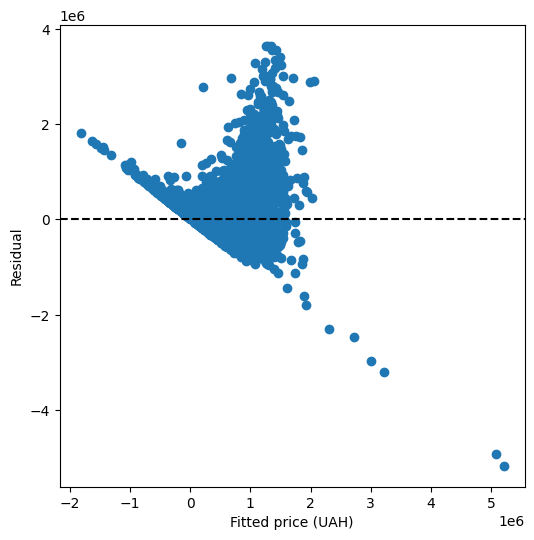

In [ ]:
ax = plt.subplots(figsize=(6,6))[1]
ax.scatter(results.fittedvalues, results.resid)
ax.set_xlabel('Fitted price (UAH)')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')
plt.show()

### Ridge Regression

In [ ]:
# Setup cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
K = 5  # number of folds

scaler = StandardScaler()
lambdas = 10**np.linspace(8, -2, 100) / y.std()

# Manual standardization for path plotting
X_no_intercept = X.drop('intercept', axis=1)
means = X_no_intercept.mean()
stds  = X_no_intercept.std()
Xs = (X_no_intercept - means) / stds

# Compute ridge path
soln_array = skl.ElasticNet.path(Xs, Y_subset, l1_ratio=0., alphas=lambdas)[1]
soln_path = pd.DataFrame(soln_array.T,
                         columns=X_no_intercept.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'

print(f"Ridge path computed with {len(lambdas)} lambda values")
print(f"Lambda range: {lambdas.min():.2e} to {lambdas.max():.2e}")

# Fit Ridge with cross-validation
ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=kfold)
pipeCV_ridge = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)])
pipeCV_ridge.fit(X_no_intercept, y)

tuned_ridge = pipeCV_ridge.named_steps['ridge']
print(f"Best lambda (Ridge): {tuned_ridge.alpha_:.4f}")
print(f"Best CV MSE (Ridge): {np.min(tuned_ridge.mse_path_.mean(1)):.1f}")

Ridge path computed with 100 lambda values
Lambda range: 1.96e-08 to 1.96e+02
Best lambda (Ridge): 0.0017
Best CV MSE (Ridge): 139623984203.7


### Lasso Regression

In [ ]:
lassoCV = skl.ElasticNetCV(n_alphas=100, l1_ratio=1, cv=kfold)
pipeCV_lasso = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])
pipeCV_lasso.fit(X_no_intercept, y)

tuned_lasso = pipeCV_lasso.named_steps['lasso']
print(f"Best lambda (Lasso): {tuned_lasso.alpha_:.4f}")
print(f"Best CV MSE (Lasso): {np.min(tuned_lasso.mse_path_.mean(1)):.1f}")

# Compute Lasso path for plotting
lambdas_lasso, soln_array_lasso = skl.Lasso.path(Xs, Y_subset, n_alphas=100)[:2]
soln_path_lasso = pd.DataFrame(soln_array_lasso.T,
                               columns=X_no_intercept.columns,
                               index=-np.log(lambdas_lasso))

# Count selected features
final_coefs = tuned_lasso.coef_
n_selected = np.sum(np.abs(final_coefs) > 1e-6)
print(f"Number of selected features: {n_selected} out of {len(final_coefs)}")

# Show selected features
selected_features = X_no_intercept.columns[np.abs(final_coefs) > 1e-6]
print(f"Selected features: {list(selected_features)}")

Best lambda (Lasso): 407.3679
Best CV MSE (Lasso): 139621211600.5
Number of selected features: 18 out of 18
Selected features: ['age', 'engineVolume_l', 'photoCount', 'descriptionLen', 'level', 'categoryName[Автобудинки]', 'categoryName[Автобуси]', 'categoryName[Вантажівки]', 'categoryName[Водний транспорт]', 'categoryName[Мото]', 'categoryName[Спецтехніка]', 'isSold[True]', 'techCondition_title[Невідремонтовані пошкодження]', 'techCondition_title[Повністю непошкоджене]', 'techCondition_title[Професійно відремонтовані пошкодження]', 'raceInt:age', 'poly(raceInt, degree=2, raw=True)[0]', 'poly(raceInt, degree=2, raw=True)[1]']


### Cross Validation (for each method)

In [ ]:
# Initialize results storage
methods = ['Linear Regression', 'Best Subset Selection', 'Ridge Regression', 'Lasso Regression']
cv_errors = np.zeros(len(methods))

print("Computing cross-validation errors...")

# Cross-validation loop for each method
cv = KFold(n_splits=5, shuffle=True, random_state=0)

# Add null model for comparison
Xn = np.zeros((X_no_intercept.shape[0], 1))
cv_null = cross_validate(LinearRegression(), Xn, y, cv=cv, scoring='neg_mean_squared_error')
null_mse = -np.mean(cv_null['test_score'])

print(f"\nNull model (intercept only) CV MSE: {null_mse:.2f}")

for i, method in enumerate(methods):
    if method == 'Linear Regression':
        # Simple linear regression
        model_lr = LinearRegression()
        cv_results = cross_validate(model_lr, X_no_intercept, y, cv=cv, scoring='neg_mean_squared_error')
        cv_errors[i] = -np.mean(cv_results['test_score'])

    elif method == 'Best Subset Selection':
        # For best subset, we'll use the best solution from the path and evaluate it with CV
        # This is a simplified approach - ideally we'd do subset selection within each CV fold
        best_features_idx = np.where(best_sol['B'] != 0)[0]
        if len(best_features_idx) > 0:
            X_selected = X_no_intercept.iloc[:, best_features_idx]
            model_subset = LinearRegression()
            cv_results = cross_validate(model_subset, X_selected, y, cv=cv, scoring='neg_mean_squared_error')
            cv_errors[i] = -np.mean(cv_results['test_score'])
        else:
            cv_errors[i] = null_mse  # If no features selected, use null model performance

    elif method == 'Ridge Regression':
        # Ridge with nested CV for lambda selection
        inner_cv = KFold(n_splits=5, shuffle=True, random_state=2)
        ridgeCV_nested = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=inner_cv)
        pipe_ridge = Pipeline(steps=[('scaler', StandardScaler()), ('ridge', ridgeCV_nested)])
        cv_results = cross_validate(pipe_ridge, X_no_intercept, y, cv=cv, scoring='neg_mean_squared_error')
        cv_errors[i] = -np.mean(cv_results['test_score'])

    elif method == 'Lasso Regression':
        # Lasso with nested CV for lambda selection
        inner_cv = KFold(n_splits=5, shuffle=True, random_state=2)
        lassoCV_nested = skl.ElasticNetCV(n_alphas=100, l1_ratio=1, cv=inner_cv)
        pipe_lasso = Pipeline(steps=[('scaler', StandardScaler()), ('lasso', lassoCV_nested)])
        cv_results = cross_validate(pipe_lasso, X_no_intercept, y, cv=cv, scoring='neg_mean_squared_error')
        cv_errors[i] = -np.mean(cv_results['test_score'])

# Create results summary
results_summary = pd.DataFrame({
    'Method': methods,
    'CV MSE': cv_errors
}).sort_values('CV MSE')

print(results_summary.round(2))

# Find best method
best_method = results_summary.iloc[0]['Method']
best_mse = results_summary.iloc[0]['CV MSE']

print(f"\nBest Method: {best_method}")
print(f"Best CV MSE: {best_mse:.2f}")

Computing cross-validation errors...

Null model (intercept only) CV MSE: 260091017468.25
                  Method        CV MSE
2       Ridge Regression  1.396165e+11
0      Linear Regression  1.396330e+11
3       Lasso Regression  1.396703e+11
1  Best Subset Selection  1.479714e+11

Best Method: Ridge Regression
Best CV MSE: 139616527721.58


## Classification (isSold)

In [ ]:
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
# Helper to build a full confusion-matrix table + metrics
from sklearn.metrics import confusion_matrix
def confusion_matrix_explained(y_true, y_pred, positive_label=1,
                               pos_name='Positive', neg_name='Negative'):
    y_true_bin = np.array(y_true) == positive_label
    y_pred_bin = np.array(y_pred) == positive_label

    tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin).ravel()

    cm_df = pd.DataFrame(
        [[tp, fn],
         [fp, tn]],
        index=[f'Actual {pos_name}',   f'Actual {neg_name}'],
        columns=[f'Predicted {pos_name}', f'Predicted {neg_name}']
    )

    total       = tp + tn + fp + fn
    accuracy    = (tp + tn) / total
    precision   = tp / (tp + fp) if (tp + fp) else np.nan
    recall      = tp / (tp + fn) if (tp + fn) else np.nan
    specificity = tn / (tn + fp) if (tn + fp) else np.nan

    metrics = dict(TP=tp, FP=fp, FN=fn, TN=tn,
                   Accuracy=accuracy, Precision=precision,
                   Recall=recall, Specificity=specificity, Total=total)
    return cm_df, metrics

### Logistic Regression

In [ ]:
Auto['raceInt'] = Auto['raceInt'] / 1000

y = Auto['isSold'].astype(int)
X = MS(numeric_terms + ['UAH', 'raceInt']).fit_transform(Auto)


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# 4. Fit a Binomial GLM
glm_binom = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_binom.fit()

# 5. Predict probabilities on the held‐out set
probs = results.predict(X_test)



# inspect
print(probs[:10])

autoId
38010668    0.392998
38050039    0.332256
38266987    0.400380
38217146    0.381809
37954985    0.383291
32390576    0.353810
37987505    0.357890
37958496    0.397728
38426455    0.406621
38390065    0.392190
dtype: float64


In [ ]:
labels = probs > 0.5
confusion_table(labels, y_test)

Truth,0,1
Predicted,,
0,1870,1098
1,31,36


In [ ]:
np.mean(labels == y_test)

0.628006589785832

### K-nearest Neighbors

In [ ]:
# ---------------------------------------------------------------------
# K-nearest neighbours, k = 1
# ---------------------------------------------------------------------
from sklearn.metrics import roc_auc_score  # NEW: for AUC

knn1 = KNeighborsClassifier(n_neighbors=1)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, y_train)

# hard class predictions  ➜ confusion matrix + accuracy
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, y_test)

Truth,0,1
Predicted,,
0,1701,274
1,200,860


In [ ]:
np.mean(knn1_pred == y_test)

0.8438220757825371

In [ ]:
# probability predictions for AUC
knn1_prob = knn1.predict_proba(X_test)[:, 1]

# accuracy
print("accuracy :", round(np.mean(knn1_pred == y_test),2))
# new AUC metric
print("AUC      :", round(roc_auc_score(y_test, knn1_prob),2))

print(confusion_table(knn1_pred, y_test) )

accuracy : 0.84
AUC      : 0.83
Truth         0    1
Predicted           
0          1701  274
1           200  860


In [ ]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3_pred = knn3.fit(X_train, y_train).predict(X_test)
np.mean(knn3_pred == y_test)

0.8313014827018121

In [ ]:
best_k   = None
best_auc = -1.0
best_pred = None          # will hold ŷ for the best model

for K in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train, y_train).predict(X_test)
    knn_prob = knn.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, knn_prob)

    # --- print1 part
    C = confusion_table(knn_pred, y_test)   # keeps your counts
    pred_total = C.loc[1].sum()
    did_rent   = C.loc[1, 1]
    acc = did_rent / pred_total
    print(f'K={K}: # predicted sold {pred_total}, # who did sold {did_rent}, '
          f'accuracy {acc:3.1%}, AUC {auc:.3f}')

    # --- keep track of the best outcome
    if auc > best_auc:
        best_auc  = auc
        best_k    = K
        best_pred = knn_pred          # save the 0/1 labels for the matrix

print("\n  BEST AUC")
print(f"k = {best_k}, AUC = {best_auc:.3f}")

# NOW show its confusion matrix **without assigning**, so it prints
confusion_table(best_pred, y_test)



K=1: # predicted sold 1060, # who did sold 860, accuracy 81.1%, AUC 0.827
K=2: # predicted sold 771, # who did sold 673, accuracy 87.3%, AUC 0.867
K=3: # predicted sold 1016, # who did sold 819, accuracy 80.6%, AUC 0.878
K=4: # predicted sold 805, # who did sold 677, accuracy 84.1%, AUC 0.883
K=5: # predicted sold 998, # who did sold 781, accuracy 78.3%, AUC 0.883
K=6: # predicted sold 807, # who did sold 655, accuracy 81.2%, AUC 0.878
K=7: # predicted sold 933, # who did sold 717, accuracy 76.8%, AUC 0.873
K=8: # predicted sold 779, # who did sold 619, accuracy 79.5%, AUC 0.866
K=9: # predicted sold 887, # who did sold 666, accuracy 75.1%, AUC 0.859
K=10: # predicted sold 765, # who did sold 590, accuracy 77.1%, AUC 0.853
K=11: # predicted sold 867, # who did sold 641, accuracy 73.9%, AUC 0.846
K=12: # predicted sold 752, # who did sold 560, accuracy 74.5%, AUC 0.839
K=13: # predicted sold 836, # who did sold 613, accuracy 73.3%, AUC 0.834
K=14: # predicted sold 726, # who did sold 53

Truth,0,1
Predicted,,
0,1773,457
1,128,677


In [ ]:
#import numpy as np    #already loaded
#import pandas as pd   #already loaded
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import ISLP           #already loaded
from ISLP import load_data
import seaborn as sns
from sklearn.model_selection import train_test_split #already loaded???

from sklearn.linear_model import LogisticRegression
#from sklearn.pipeline import make_pipeline    #already loaded in linear models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble   import GradientBoostingClassifier, HistGradientBoostingClassifier

#from sklearn_bart import BARTClassifier

# Random forrest:

In [ ]:
# Helper functions for consistent model evaluation
# McFadden pseudo-R² helper (for models that don’t expose llf) ----------
def pseudo_r2(y, p_hat, k=0, eps=1e-15):
    """
    McFadden pseudo-R² and adjusted pseudo-R² from predicted probabilities.
    k = number of fitted predictors (exclude intercept if any).
    """
    p_hat = np.clip(p_hat, eps, 1 - eps)
    ll_model = np.sum(y * np.log(p_hat) + (1 - y) * np.log(1 - p_hat))
    p_bar    = y.mean()
    ll_null  = np.sum(y * np.log(p_bar) + (1 - y) * np.log(1 - p_bar))
    r2      = 1 - ll_model / ll_null
    r2_adj  = 1 - (ll_model - k) / ll_null
    return r2, r2_adj

In [ ]:
# Tree ensembles: base models: Random Forest & Gradient Boosting
# =============================================================
models = {
    "Random Forest": RandomForestClassifier(
                        n_estimators=500, max_features='sqrt',
                        random_state=0, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(
                        n_estimators=500, learning_rate=0.05,
                        max_depth=3, subsample=0.8,
                        random_state=0)
}

for name, mdl in models.items():
    mdl.fit(X_train, y_train)

    # Train metrics
    p_train = mdl.predict_proba(X_train)[:, 1]
    auc_train = roc_auc_score(y_train, p_train)
    r2_train, r2_adj_train = pseudo_r2(y_train, p_train) #k=0 for trees

    # Test metrics
    p_test = mdl.predict_proba(X_test)[:, 1]
    auc_test = roc_auc_score(y_test, p_test)
    r2_test, r2_adj_test = pseudo_r2(y_test, p_test)

    print(f"\n▶ {name}")
    print("-------------------------------------------")
    print(f"Train : pseudo-R²={r2_train:.3f} | adj={r2_adj_train:.3f} | AUC={auc_train:.3f}")
    print(f"Test  : pseudo-R²={r2_test:.3f} | adj={r2_adj_test:.3f} | AUC={auc_test:.3f}")


▶ Random Forest
-------------------------------------------
Train : pseudo-R²=0.733 | adj=0.733 | AUC=1.000
Test  : pseudo-R²=0.050 | adj=0.050 | AUC=0.651

▶ Gradient Boosting
-------------------------------------------
Train : pseudo-R²=0.205 | adj=0.205 | AUC=0.839
Test  : pseudo-R²=0.139 | adj=0.139 | AUC=0.765


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics  import roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# ------------------------------------------------------------------
# 1. Baseline model (depth 6, 200 trees)
# ------------------------------------------------------------------
rf_simple = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_leaf=20,
    max_features=0.30,
    random_state=0,
    n_jobs=-1
).fit(X_train, y_train)

# ---- baseline metrics ----
p_tr = rf_simple.predict_proba(X_train)[:, 1]
p_te = rf_simple.predict_proba(X_test)[:, 1]

auc_tr  = roc_auc_score(y_train, p_tr)
auc_te  = roc_auc_score(y_test,  p_te)
r2_tr, r2_adj_tr = pseudo_r2(y_train, p_tr)
r2_te, r2_adj_te = pseudo_r2(y_test,  p_te)

print("\n▶ Simple Random Forest (depth 6, 200 trees)")
print("-------------------------------------------")
print(f"Train : pseudo-R²={r2_tr:.3f} | adj={r2_adj_tr:.3f} | AUC={auc_tr:.3f}")
print(f"Test  : pseudo-R²={r2_te:.3f} | adj={r2_adj_te:.3f} | AUC={auc_te:.3f}")

# ------------------------------------------------------------------
# 2. Grid-search: 3 depths × 2 leaf sizes × 1 max_features = 6 combos
# ------------------------------------------------------------------
rf_base = RandomForestClassifier(
    n_estimators=500,
    max_features=0.30,          # fixed at 30 % of predictors
    random_state=0,
    n_jobs=-1
)

param_grid = {
    'max_depth':        [4, 6, 8],
    'min_samples_leaf': [20, 50],
    # 'max_features':   [0.15, 0.3, 0.45],   # ← uncomment to compare more combos later
}

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=cv5,
    scoring='roc_auc',
    n_jobs=-1,
    return_train_score=True
).fit(X_train, y_train)

# ------------------------------------------------------------------
# 3. CV results + external-test AUC for each combo
# ------------------------------------------------------------------
rows = []
for i, params in enumerate(search.cv_results_['params']):
    # Fit model with the exact params to get test AUC
    model_i = RandomForestClassifier(
        n_estimators=500,
        max_features=0.30,
        random_state=0,
        n_jobs=-1,
        **params
    ).fit(X_train, y_train)

    test_auc = roc_auc_score(y_test, model_i.predict_proba(X_test)[:, 1])

    rows.append({
        'max_depth' : params['max_depth'],
        'min_leaf'  : params['min_samples_leaf'],
        'cv_auc_mean': round(search.cv_results_['mean_test_score'][i], 3),
        'cv_auc_std' : round(search.cv_results_['std_test_score'][i], 3),
        'test_auc'   : round(test_auc, 3)
    })

cv_df = (pd.DataFrame(rows)
           .sort_values('cv_auc_mean', ascending=False)
           .reset_index(drop=True))

print("\n▶ Cross-validation results (sorted by validation AUC)")
print(cv_df.to_string(index=False))

# ------------------------------------------------------------------
# 4. Evaluate the best CV model on full train / test sets
# ------------------------------------------------------------------
best_rf = search.best_estimator_

p_tr_best = best_rf.predict_proba(X_train)[:, 1]
p_te_best = best_rf.predict_proba(X_test)[:, 1]

auc_tr_b  = roc_auc_score(y_train, p_tr_best)
auc_te_b  = roc_auc_score(y_test,  p_te_best)
r2_tr_b, r2_adj_tr_b = pseudo_r2(y_train, p_tr_best)
r2_te_b, r2_adj_te_b = pseudo_r2(y_test,  p_te_best)

print("\n▶ Tuned Random Forest (anti-overfit)")
print("-------------------------------------------")
print("Best params:", search.best_params_)
print(f"Train : pseudo-R²={r2_tr_b:.3f} | adj={r2_adj_tr_b:.3f} | AUC={auc_tr_b:.3f}")
print(f"Test  : pseudo-R²={r2_te_b:.3f} | adj={r2_adj_te_b:.3f} | AUC={auc_te_b:.3f}")


##prompt:
#fix the code.
#it show the same thing twice, while I wanted it to explore the params and show all options and then the best one
#use params from params grid to explore

#param 'max_features': ['sqrt', 0.3] was remowed. results showed no difference between 'sqrt' and 0.3

#prompts:


▶ Simple Random Forest (depth 6, 200 trees)
-------------------------------------------
Train : pseudo-R²=0.058 | adj=0.058 | AUC=0.682
Test  : pseudo-R²=0.040 | adj=0.040 | AUC=0.644

▶ Cross-validation results (sorted by validation AUC)
 max_depth  min_leaf  cv_auc_mean  cv_auc_std  test_auc
         8        20        0.643       0.015     0.653
         6        20        0.637       0.017     0.646
         8        50        0.636       0.015     0.648
         6        50        0.633       0.016     0.642
         4        20        0.626       0.018     0.635
         4        50        0.624       0.018     0.633

▶ Tuned Random Forest (anti-overfit)
-------------------------------------------
Best params: {'max_depth': 8, 'min_samples_leaf': 20}
Train : pseudo-R²=0.081 | adj=0.081 | AUC=0.716
Test  : pseudo-R²=0.047 | adj=0.047 | AUC=0.653


In [ ]:
# 1. Grid-search: (1 depth) × (1 leaf size) × (3 max_features)
# --------------------------------------------------------------
rf_base = RandomForestClassifier(
    n_estimators=200, #Sets the ensemble size. diminishing returns
    random_state=0, #fixes a repeatable sequence of random numbers
    n_jobs=-1       #-1 means “spawn as many worker threads as there are logical CPU cores.
)

param_grid = {
    'max_depth':        [8],
    'min_samples_leaf': [20],
    'max_features':     [0.15, 0.30, 0.45, 0.6, 0.8, 1]
}

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=cv5,
    scoring='roc_auc',
    n_jobs=-1,
    return_train_score=True
).fit(X_train, y_train)

# --------------------------------------------------------------
# 2. Build table: CV AUC + external-test AUC for every combo
# --------------------------------------------------------------
rows = []
for i, params in enumerate(search.cv_results_['params']):
    # Re-fit model with the exact params to get test AUC
    model_i = RandomForestClassifier(
        n_estimators=500,
        random_state=0,
        n_jobs=-1,
        **params
    ).fit(X_train, y_train)

    test_auc = roc_auc_score(y_test, model_i.predict_proba(X_test)[:, 1])

    rows.append({
        'max_features': params['max_features'],
        'cv_auc_mean': round(search.cv_results_['mean_test_score'][i], 3),
        'cv_auc_std' : round(search.cv_results_['std_test_score'][i], 3),
        'test_auc'   : round(test_auc, 3)
    })

cv_df = (pd.DataFrame(rows)
           .sort_values('cv_auc_mean', ascending=False)
           .reset_index(drop=True))

print("\n▶ Cross-validation results (sorted by validation AUC)")
print(cv_df.to_string(index=False))

# --------------------------------------------------------------
# 3. Evaluate the best model on full train / test sets
# --------------------------------------------------------------
best_rf = search.best_estimator_

p_tr = best_rf.predict_proba(X_train)[:, 1]
p_te = best_rf.predict_proba(X_test)[:, 1]

auc_tr  = roc_auc_score(y_train, p_tr)
auc_te  = roc_auc_score(y_test,  p_te)
r2_tr, r2_adj_tr = pseudo_r2(y_train, p_tr)
r2_te, r2_adj_te = pseudo_r2(y_test,  p_te)

print("\n▶ Best Random Forest (max_features tuned)")
print("-------------------------------------------")
print("Best params:", search.best_params_)
print(f"Train : pseudo-R²={r2_tr:.3f} | adj={r2_adj_tr:.3f} | AUC={auc_tr:.3f}")
print(f"Test  : pseudo-R²={r2_te:.3f} | adj={r2_adj_te:.3f} | AUC={auc_te:.3f}")


▶ Cross-validation results (sorted by validation AUC)
 max_features  cv_auc_mean  cv_auc_std  test_auc
         0.80        0.660       0.014     0.674
         0.60        0.652       0.014     0.665
         0.45        0.649       0.015     0.659
         0.30        0.643       0.016     0.653
         0.15        0.637       0.016     0.644
         1.00        0.637       0.016     0.644

▶ Best Random Forest (max_features tuned)
-------------------------------------------
Best params: {'max_depth': 8, 'max_features': 0.8, 'min_samples_leaf': 20}
Train : pseudo-R²=0.113 | adj=0.113 | AUC=0.752
Test  : pseudo-R²=0.062 | adj=0.062 | AUC=0.674


Not a big difference in performance by changing the max feautures param

# Gradient Boost: finding best version (slow implementation)

In [ ]:
# ------------------------------------------------------------------
# Gradient Boosting – baseline, grid search, evaluation
# ------------------------------------------------------------------

#from sklearn.ensemble   import GradientBoostingClassifier
#from sklearn.metrics    import roc_auc_score
#from sklearn.model_selection import GridSearchCV, StratifiedKFold

# ------------------------------------------------------------------
# 1. Baseline model (depth 3, LR 0.05, 200 trees, 80 % subsample)
# ------------------------------------------------------------------
gb_simple = GradientBoostingClassifier(
    n_estimators     = 500,
    learning_rate    = 0.05,
    max_depth        = 3,
    subsample        = 0.80,
    min_samples_leaf = 20,
    random_state     = 0
).fit(X_train, y_train)

p_tr = gb_simple.predict_proba(X_train)[:, 1]
p_te = gb_simple.predict_proba(X_test)[:, 1]

auc_tr  = roc_auc_score(y_train, p_tr)
auc_te  = roc_auc_score(y_test,  p_te)
r2_tr, r2_adj_tr = pseudo_r2(y_train, p_tr)
r2_te, r2_adj_te = pseudo_r2(y_test,  p_te)

print("\n▶ Simple Gradient Boosting (depth 3, LR 0.05, 200 trees)")
print("---------------------------------------------------------")
print(f"Train : pseudo-R²={r2_tr:.3f} | adj={r2_adj_tr:.3f} | AUC={auc_tr:.3f}")
print(f"Test  : pseudo-R²={r2_te:.3f} | adj={r2_adj_te:.3f} | AUC={auc_te:.3f}")

# ------------------------------------------------------------------
# 2. Grid search
# ------------------------------------------------------------------
gb_base = GradientBoostingClassifier(
    n_estimators = 500,          # keep trees fixed to compare apples-to-apples
    random_state = 0
)

param_grid = {
    'max_depth'       : [2, 3, 4],
    'learning_rate'   : [0.05, 0.10],
    'subsample'       : [0.80, 1.00],
    'min_samples_leaf': [20, 50]
    # NOTE: no max_features – not used in sklearn GBM and you said it didn’t matter
}

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

search = GridSearchCV(
    estimator          = gb_base,
    param_grid         = param_grid,
    cv                 = cv5,
    scoring            = 'roc_auc',
    n_jobs             = -1,
    return_train_score = True
).fit(X_train, y_train)

# ------------------------------------------------------------------
# 3. CV results + external-test AUC for each combo
# ------------------------------------------------------------------
rows = []
for i, params in enumerate(search.cv_results_['params']):
    # fit the exact combo to get a fair hold-out test AUC
    model_i = GradientBoostingClassifier(
        n_estimators = 500,
        random_state = 0,
        **params
    ).fit(X_train, y_train)

    test_auc = roc_auc_score(y_test, model_i.predict_proba(X_test)[:, 1])

    rows.append({
        'depth'   : params['max_depth'],
        'lr'      : params['learning_rate'],
        'sample'  : params['subsample'],
        'leaf'    : params['min_samples_leaf'],
        'cv_auc_mean': round(search.cv_results_['mean_test_score'][i], 3),
        'cv_auc_std' : round(search.cv_results_['std_test_score'][i], 3),
        'test_auc'   : round(test_auc, 3)
    })

cv_df = (pd.DataFrame(rows)
           .sort_values('cv_auc_mean', ascending=False)
           .reset_index(drop=True))

print("\n▶ Cross-validation results (sorted by validation AUC)")
print(cv_df.to_string(index=False))

# ------------------------------------------------------------------
# 4. Evaluate the best CV model on full train / test sets
# ------------------------------------------------------------------
best_gb = search.best_estimator_

p_tr_best = best_gb.predict_proba(X_train)[:, 1]
p_te_best = best_gb.predict_proba(X_test)[:, 1]

auc_tr_b  = roc_auc_score(y_train, p_tr_best)
auc_te_b  = roc_auc_score(y_test,  p_te_best)
r2_tr_b, r2_adj_tr_b = pseudo_r2(y_train, p_tr_best)
r2_te_b, r2_adj_te_b = pseudo_r2(y_test,  p_te_best)

print("\n▶ Tuned Gradient Boosting (best of grid)")
print("-------------------------------------------")
print("Best params:", search.best_params_)
print(f"Train : pseudo-R²={r2_tr_b:.3f} | adj={r2_adj_tr_b:.3f} | AUC={auc_tr_b:.3f}")
print(f"Test  : pseudo-R²={r2_te_b:.3f} | adj={r2_adj_te_b:.3f} | AUC={auc_te_b:.3f}")


▶ Simple Gradient Boosting (depth 3, LR 0.05, 200 trees)
---------------------------------------------------------
Train : pseudo-R²=0.193 | adj=0.193 | AUC=0.826
Test  : pseudo-R²=0.135 | adj=0.135 | AUC=0.759

▶ Cross-validation results (sorted by validation AUC)
 depth   lr  sample  leaf  cv_auc_mean  cv_auc_std  test_auc
     4 0.10     1.0    20        0.858       0.010     0.871
     4 0.10     0.8    20        0.819       0.006     0.836
     4 0.05     1.0    20        0.812       0.013     0.825
     4 0.10     1.0    50        0.806       0.008     0.826
     3 0.10     1.0    20        0.796       0.008     0.821
     3 0.10     0.8    20        0.784       0.006     0.808
     4 0.05     0.8    20        0.777       0.007     0.801
     2 0.10     1.0    20        0.773       0.007     0.795
     4 0.05     1.0    50        0.769       0.011     0.779
     4 0.10     0.8    50        0.760       0.008     0.782
     3 0.10     1.0    50        0.758       0.011     0.778
 

In [ ]:
#making sure I can use
#need to have 1.4.2+ version

import sklearn
print(sklearn.__version__)

1.6.1


# Gradient Boost: finding best version (fast implementation)

In [ ]:
# ------------------------------------------------------------------
# Gradient Boosting – baseline, grid search, evaluation
# ------------------------------------------------------------------

#from sklearn.metrics    import roc_auc_score
#from sklearn.model_selection import GridSearchCV, StratifiedKFold

# ------------------------------------------------------------------
# 1. Baseline model (depth 3, LR 0.05, 200 trees, 80 % subsample)
# ------------------------------------------------------------------
gb_simple = HistGradientBoostingClassifier(
    max_iter        = 500,
    learning_rate    = 0.05,
    max_depth        = 3,
    #subsample        = 0.80,
    min_samples_leaf = 20,
    random_state     = 0
).fit(X_train, y_train)

p_tr = gb_simple.predict_proba(X_train)[:, 1]
p_te = gb_simple.predict_proba(X_test)[:, 1]

auc_tr  = roc_auc_score(y_train, p_tr)
auc_te  = roc_auc_score(y_test,  p_te)
r2_tr, r2_adj_tr = pseudo_r2(y_train, p_tr)
r2_te, r2_adj_te = pseudo_r2(y_test,  p_te)
# ---- adding for confussion matrix
y_pred_tr = gb_simple.predict(X_train)                 # 0/1 labels
y_pred_te = gb_simple.predict(X_test)
cm_tr, m_tr = confusion_matrix_explained(y_train, y_pred_tr)
cm_te, m_te = confusion_matrix_explained(y_test,  y_pred_te)

print("\n▶ Simple Gradient Boosting (depth 3, LR 0.05, 200 trees)")
print("---------------------------------------------------------")
print(f"Train : pseudo-R²={r2_tr:.3f} | adj={r2_adj_tr:.3f} | AUC={auc_tr:.3f}")
print(f"Test  : pseudo-R²={r2_te:.3f} | adj={r2_adj_te:.3f} | AUC={auc_te:.3f}")

print("\nConfusion matrix – TEST, simple model")
print(cm_te.to_string())
print("Metrics:", m_te)


# ------------------------------------------------------------------
# 2. Grid search
# ------------------------------------------------------------------
#was GradientBoostingClassifier initially
gb_base = HistGradientBoostingClassifier(
    max_iter        = 500,
    random_state = 0
)

param_grid = {
    'max_depth'       : [2, 3, 4],
    'learning_rate'   : [0.05, 0.10],
    #'subsample'       : [0.80, 1.00],
    'min_samples_leaf': [20, 50]
    # NOTE: no max_features – not used in sklearn GBM and you said it didn’t matter
}

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

search = GridSearchCV(
    estimator          = gb_base,
    param_grid         = param_grid,
    cv                 = cv5,
    scoring            = 'roc_auc',
    n_jobs             = -1,
    return_train_score = True
).fit(X_train, y_train)

# ------------------------------------------------------------------
# 3. CV results + external-test AUC for each combo
# ------------------------------------------------------------------
rows = []
for i, params in enumerate(search.cv_results_['params']):
    # fit the exact combo to get a fair hold-out test AUC
    model_i = HistGradientBoostingClassifier(   #was GradientBoostingClassifier initially
        max_iter = 500,
        random_state = 0,
        **params
    ).fit(X_train, y_train)

    test_auc = roc_auc_score(y_test, model_i.predict_proba(X_test)[:, 1])

    rows.append({
        'depth'   : params['max_depth'],
        'lr'      : params['learning_rate'],
        #'sample'  : params['subsample'],
        'leaf'    : params['min_samples_leaf'],
        'cv_auc_mean': round(search.cv_results_['mean_test_score'][i], 3),
        'cv_auc_std' : round(search.cv_results_['std_test_score'][i], 3),
        'test_auc'   : round(test_auc, 3)
    })

cv_df = (pd.DataFrame(rows)
           .sort_values('cv_auc_mean', ascending=False)
           .reset_index(drop=True))

print("\n▶ Cross-validation results (sorted by validation AUC)")
print(cv_df.to_string(index=False))

# ------------------------------------------------------------------
# 4. Evaluate the best CV model on full train / test sets
# ------------------------------------------------------------------
best_gb = search.best_estimator_

p_tr_best = best_gb.predict_proba(X_train)[:, 1]
p_te_best = best_gb.predict_proba(X_test)[:, 1]

auc_tr_b  = roc_auc_score(y_train, p_tr_best)
auc_te_b  = roc_auc_score(y_test,  p_te_best)
r2_tr_b, r2_adj_tr_b = pseudo_r2(y_train, p_tr_best)
r2_te_b, r2_adj_te_b = pseudo_r2(y_test,  p_te_best)

# ---- NEW: hard labels + confusion matrix for the tuned model ----
y_pred_tr_b = best_gb.predict(X_train)
y_pred_te_b = best_gb.predict(X_test)

cm_tr_b, m_tr_b = confusion_matrix_explained(y_train, y_pred_tr_b)
cm_te_b, m_te_b = confusion_matrix_explained(y_test,  y_pred_te_b)
# -----------------------------------------------------------------

print("\n▶ Tuned Gradient Boosting (best of grid)")
print("-------------------------------------------")
print("Best params:", search.best_params_)
print(f"Train : pseudo-R²={r2_tr_b:.3f} | adj={r2_adj_tr_b:.3f} | AUC={auc_tr_b:.3f}")
print(f"Test  : pseudo-R²={r2_te_b:.3f} | adj={r2_adj_te_b:.3f} | AUC={auc_te_b:.3f}")

print("\nConfusion matrix – TEST, best model")
print(cm_te_b.to_string())          # ← use the *_b variables
print("Metrics:", m_te_b)


▶ Simple Gradient Boosting (depth 3, LR 0.05, 200 trees)
---------------------------------------------------------
Train : pseudo-R²=0.086 | adj=0.086 | AUC=0.703
Test  : pseudo-R²=0.058 | adj=0.058 | AUC=0.663

Confusion matrix – TEST, simple model
                 Predicted Positive  Predicted Negative
Actual Positive                 204                 930
Actual Negative                 110                1791
Metrics: {'TP': 204, 'FP': 110, 'FN': 930, 'TN': 1791, 'Accuracy': 0.657331136738056, 'Precision': 0.6496815286624203, 'Recall': 0.17989417989417988, 'Specificity': 0.9421357180431352, 'Total': 3035}

▶ Cross-validation results (sorted by validation AUC)
 depth   lr  leaf  cv_auc_mean  cv_auc_std  test_auc
     4 0.10    20        0.708       0.011     0.673
     3 0.10    20        0.703       0.013     0.659
     4 0.05    20        0.700       0.013     0.670
     4 0.10    50        0.694       0.016     0.661
     2 0.10    20        0.692       0.011     0.646
     3 0